In [1]:
import pandas as pd
import numpy as np
import scipy as sc
from matplotlib import pyplot
from numpy.polynomial.polynomial import polyfit
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import RFECV
from sklearn.feature_selection import RFE
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
import pickle
from sklearn.cross_decomposition import PLSRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.ensemble import StackingRegressor

In [2]:
df = pd.read_csv('PhDdata/reflectance.csv')

In [3]:
df_T = df.iloc[:,1:].transpose()
df_T.columns = list(df['No'])
df_T.insert(loc=2, column='No', value=range(85))

In [4]:
imputer = SimpleImputer(strategy='mean')
df_im = imputer.fit_transform(df_T)
df_im = pd.DataFrame(df_im, columns = df_T.columns)
df_im

,WP(kpa),DAF_vineyard,No,400,401,402,403,404,405,406,...,2391,2392,2393,2394,2395,2396,2397,2398,2399,2400
0,506.764661,9.0,0.0,0.063850,0.062331,0.062199,0.061265,0.059340,0.059004,0.058986,...,0.119277,0.118608,0.117974,0.117404,0.116857,0.116380,0.115860,0.115206,0.114649,0.114148
1,482.633011,9.0,1.0,0.058584,0.057235,0.056744,0.055810,0.054320,0.053807,0.053880,...,0.101248,0.100786,0.100312,0.099758,0.099175,0.098579,0.098096,0.097606,0.097086,0.096588
2,379.211651,9.0,2.0,0.064389,0.063101,0.062375,0.060985,0.059040,0.058502,0.058738,...,0.114490,0.114000,0.113505,0.113069,0.112514,0.111889,0.111356,0.110781,0.110245,0.109771
3,430.922331,9.0,3.0,0.064308,0.063109,0.062726,0.061289,0.059077,0.059202,0.059800,...,0.111532,0.110909,0.110351,0.109754,0.109224,0.108771,0.108242,0.107761,0.107251,0.106688
4,492.975146,9.0,4.0,0.064402,0.063405,0.062922,0.061625,0.059709,0.059388,0.059563,...,0.114957,0.114410,0.113940,0.113398,0.112815,0.112343,0.111736,0.111149,0.110647,0.110002
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80,1344.477672,57.0,80.0,0.075322,0.073179,0.072089,0.070445,0.068187,0.067400,0.067113,...,0.102281,0.101664,0.101124,0.100651,0.100137,0.099560,0.098987,0.098381,0.097771,0.097144
81,1085.924274,57.0,81.0,0.076315,0.073566,0.072683,0.071415,0.069225,0.068030,0.067819,...,0.103288,0.102691,0.102112,0.101547,0.100941,0.100392,0.099790,0.099212,0.098720,0.098125
82,844.607768,57.0,82.0,0.078267,0.076038,0.075188,0.073785,0.071584,0.070647,0.070370,...,0.102399,0.101795,0.101238,0.100672,0.100044,0.099481,0.099008,0.098566,0.098156,0.097726
83,1077.305827,57.0,83.0,0.080576,0.078358,0.077521,0.075924,0.073580,0.073289,0.073050,...,0.106552,0.105896,0.105369,0.104820,0.104255,0.103803,0.103306,0.102755,0.102192,0.101566


In [5]:
#train_test dataset splitting (stratified with DAF and vineyard)
X, y = df_im.iloc[:,2:].values, df_im.iloc[:,0].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0, stratify=df_im.iloc[:,1])
X_train[:,0]

array([67., 30., 17., 47., 71., 29., 46., 36., 14., 78., 12., 18.,  8.,
       56., 34.,  7., 49., 76., 16., 26., 82., 35.,  0., 23., 83., 68.,
       27., 51.,  6., 22., 64., 54., 32., 15., 80., 11., 40., 10., 58.,
       28., 55., 70.,  2., 43., 72., 77., 73.,  3.,  4., 24., 84., 62.,
       50., 44., 37., 38., 59., 52., 66.])

In [6]:
np.mean(y_train), np.mean(y_test), np.std(y_train), np.std(y_test)

(751.2071791745765, 753.8488960153845, 273.0971107218118, 279.1635657978622)

In [6]:
#Standardization
scaler_st = StandardScaler()
X_train_st = scaler_st.fit_transform(X_train[:,1:])
X_test_st = scaler_st.transform(X_test[:,1:])
X_train_st = np.insert(X_train_st, 0, X_train[:,0], axis=1)
X_test_st = np.insert(X_test_st, 0, X_test[:,0], axis=1)

In [7]:
#Spearman correlation>0.6
df_pear = np.insert(X_train[:,1:], 0, y_train, axis=1)
rho, pval = sc.stats.spearmanr(df_pear)
corr_sp = rho[1:,0]
corr_sp = corr_sp.reshape(2001,1)
corr_sp = pd.DataFrame(corr_sp, columns = ['spear'])
corr_sp ['No'] = df_im.columns[3:]
corr_sp ['p'] = pval[1:,0]
feature_pear = corr_sp[corr_sp['spear']<-0.6].append(corr_sp[corr_sp['spear']>0.6])
feature_pear = feature_pear[feature_pear['spear']<1]
#feature_pear.to_csv('H:/result_n/refl_spear06.csv')
feature_pear

,spear,No,p
338,0.601377,738,4.730252e-07
339,0.620025,739,1.632917e-07
340,0.623708,740,1.312636e-07
341,0.631893,741,7.997776e-08
342,0.639171,742,5.084773e-08
...,...,...,...
1266,0.601757,1666,4.631960e-07
1267,0.601757,1667,4.631960e-07
1268,0.600558,1668,4.948643e-07
1269,0.600558,1669,4.948643e-07


In [7]:
#load trained model
rfe_rf = pickle.load(open('trained_model/rfe_rf_refl', 'rb'))
rfe_rf_trans = pickle.load(open('trained_model/rfe_rf_trans_refl', 'rb'))
rfe_svr = pickle.load(open('trained_model/rfe_svr_refl', 'rb'))
rfe_svr_trans = pickle.load(open('trained_model/rfe_svr_trans_refl', 'rb'))

In [7]:
#carefully select the parameter range to prevent overfitting, then use these ranges for modeling
#Full: partial least squares regression (use default scale = True for X, y)
plsr_full_plsr = PLSRegression()
para_full_plsr = {'n_components':[1,2,3,4,5,6,7,8,9,10]}
gs_full_plsr = GridSearchCV(plsr_full_plsr, para_full_plsr, cv = 10, scoring='r2')
gs_full_plsr.fit(X_train[:,1:], y_train)
gs_full_plsr.best_estimator_

PLSRegression(n_components=9)

In [8]:
full_plsr_tune = PLSRegression(n_components=9)
full_plsr_tune.fit(X_train[:,1:], y_train)
r2_full_plsr_train = full_plsr_tune.score(X_train[:, 1:], y_train)
r2_full_plsr = full_plsr_tune.score(X_test[:,1:], y_test)
rmse_full_plsr = mean_squared_error(y_test, full_plsr_tune.predict(X_test[:,1:]), squared=False)
r2_full_plsr_train, r2_full_plsr, rmse_full_plsr

(0.8094362930908952, 0.8067753245659233, 122.71284647929242)

In [17]:
#calculate VIP
def _calculate_vips(model):
    t = model.x_scores_
    w = model.x_weights_
    q = model.y_loadings_
    p, h = w.shape
    vips = np.zeros((p,))
    s = np.diag(np.matmul(np.matmul(np.matmul(t.T,t),q.T), q)).reshape(h, -1)
    total_s = np.sum(s)
    for i in range(p):
        weight = np.array([ (w[i,j] / np.linalg.norm(w[:,j]))**2 for j in range(h) ])
        vips[i] = np.sqrt(p*(np.matmul(s.T, weight))/total_s)
    return vips

In [18]:
VIP = _calculate_vips(full_plsr_tune)
VIP_pd = pd.DataFrame()
VIP_pd['VIP'] = VIP
VIP_pd['variable'] = df_im.columns[3:] 
VIP_pd.to_csv('H:/result/refl_VIP.csv')

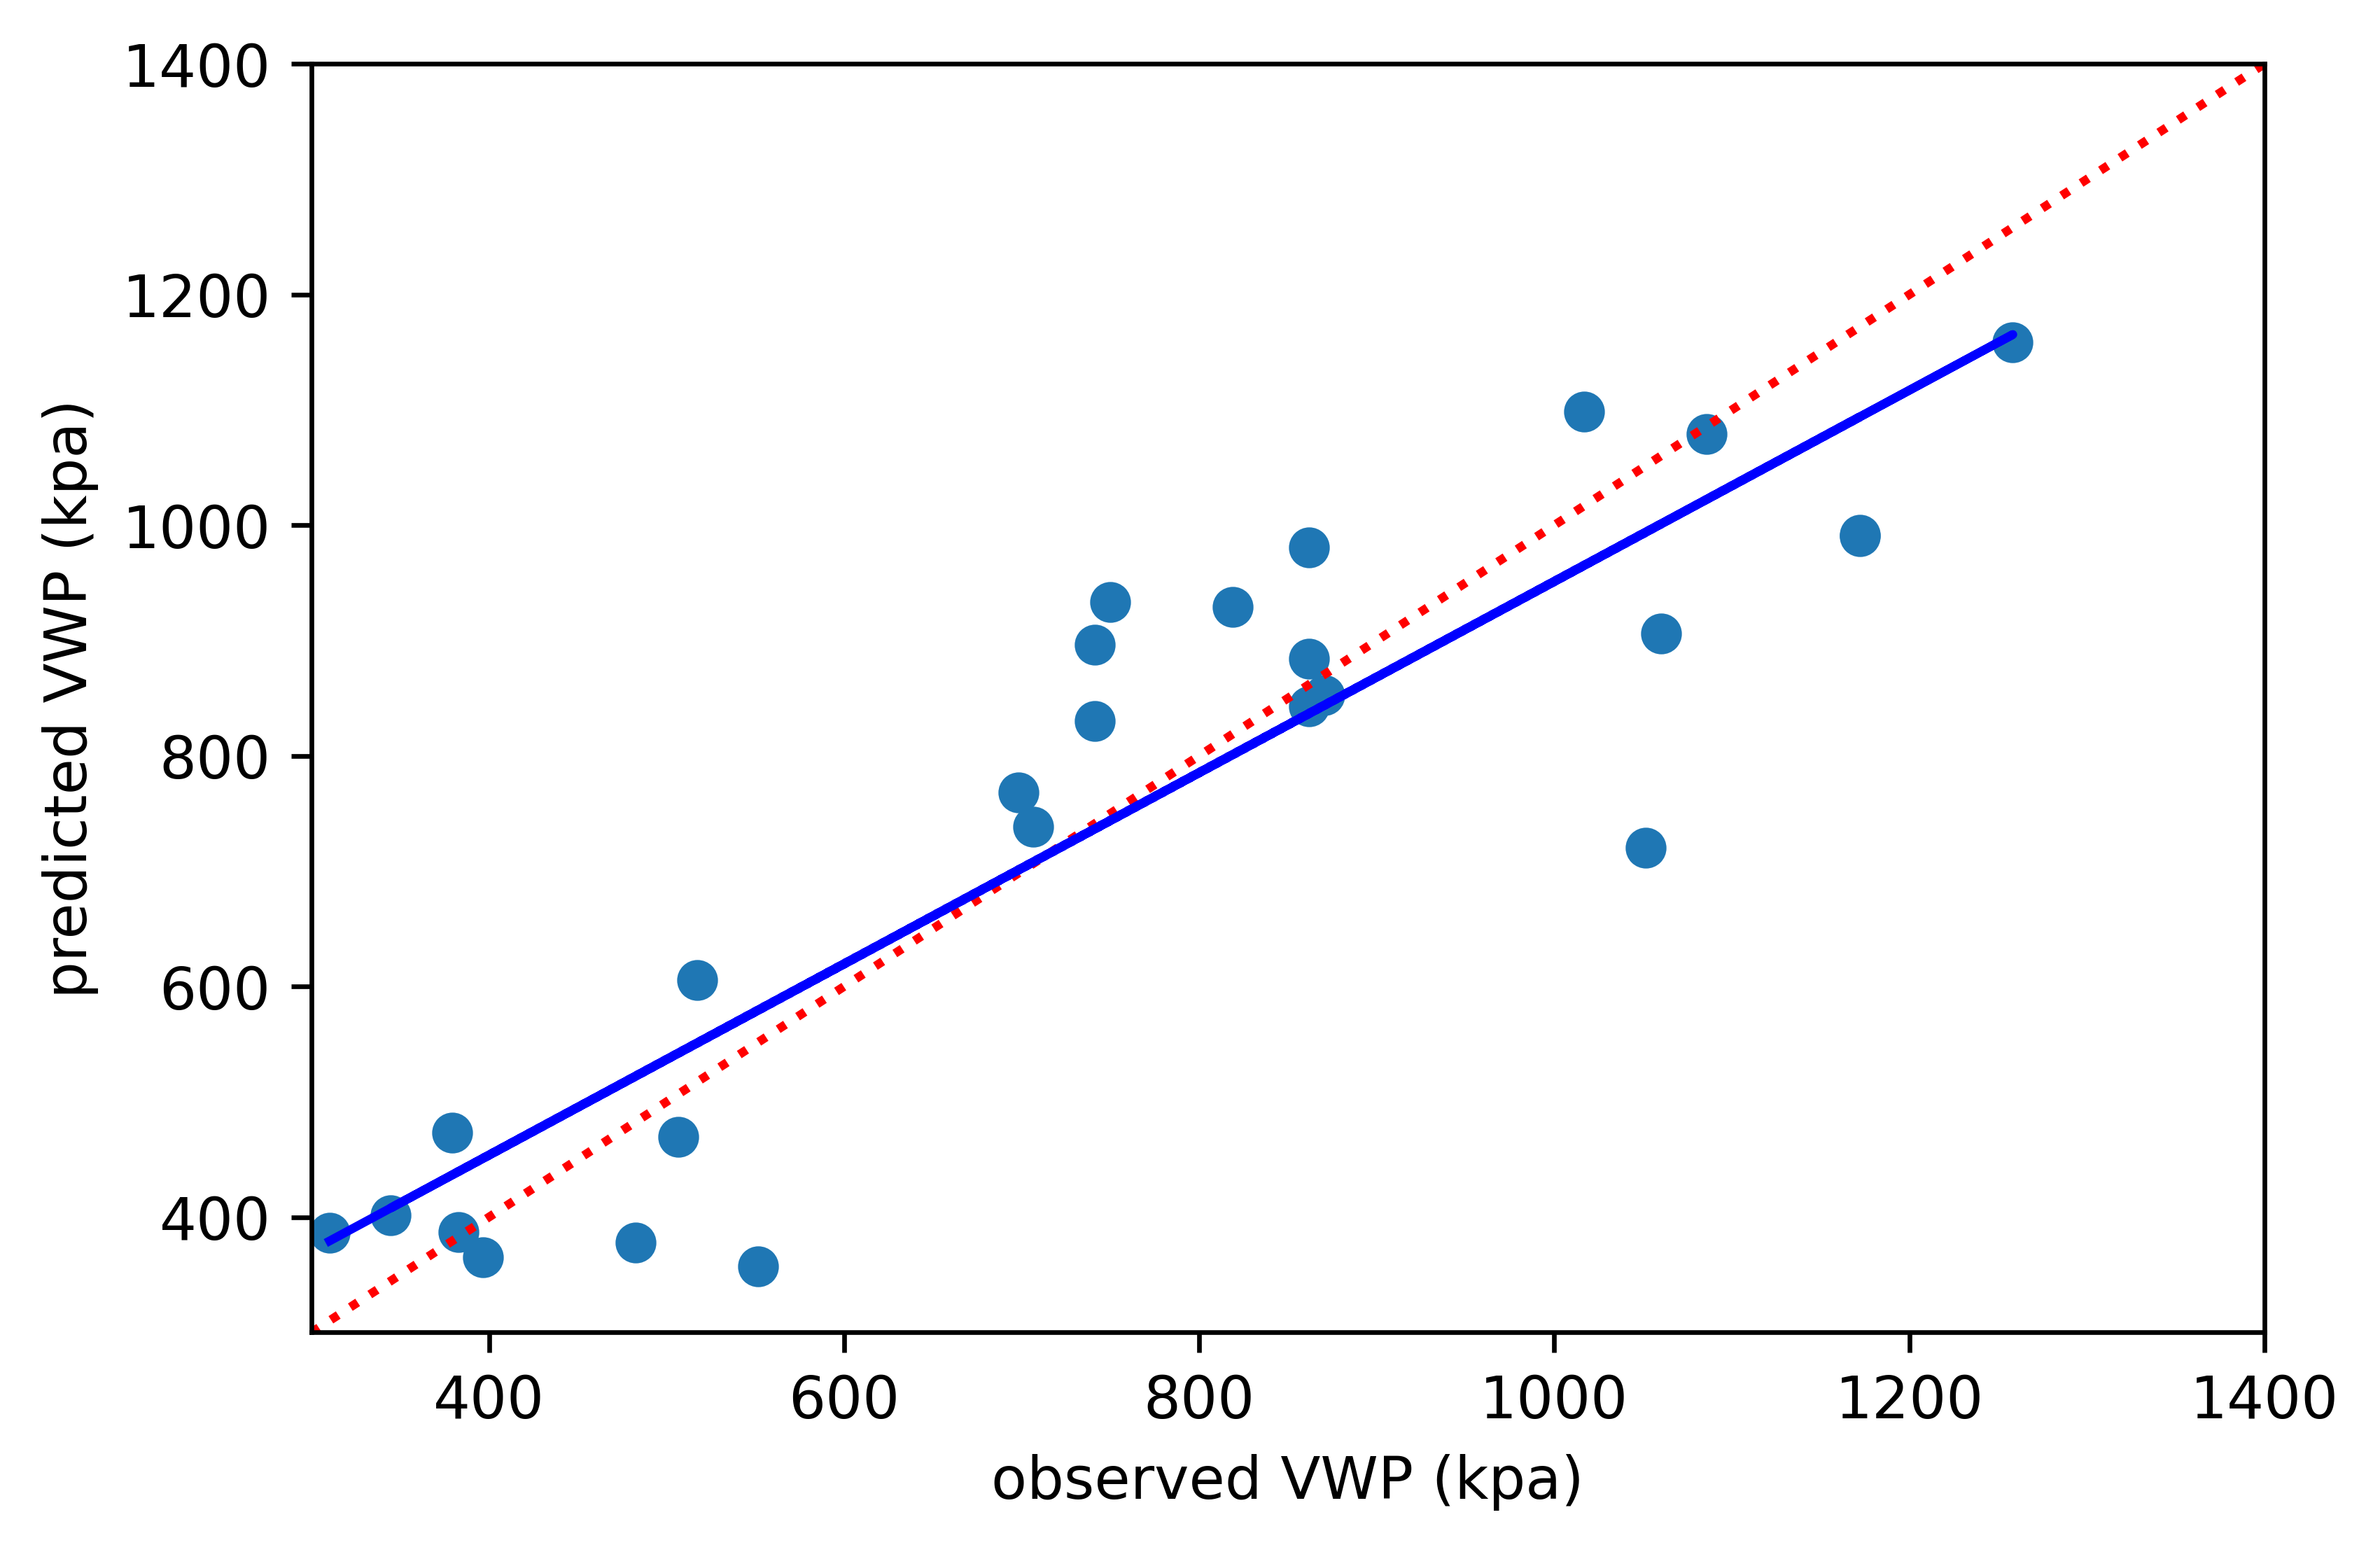

In [9]:
#make regression graph
graph_y = full_plsr_tune.predict(X_test[:,1:]) 
graph_x = y_test
pyplot.figure(dpi=600)
pyplot.plot([300,1400], [300,1400], 'r:')
pyplot.scatter(graph_x, graph_y)
b, m = polyfit(graph_x, graph_y, 1)
pyplot.plot(graph_x, m*graph_x + b, 'b-')
pyplot.ylabel('predicted VWP (kpa)')
pyplot.xlabel('observed VWP (kpa)')
pyplot.axis([300, 1400, 300, 1400])
pyplot.savefig('D:/data_hyper_ML/result_n/scatter plot_regression/rg_refl.png',dpi=600)
pyplot.show()

In [9]:
#Full: random forest
rf_full_rf = RandomForestRegressor(max_depth=1, n_estimators=500, random_state=0, n_jobs=-1)
para_full_rf = {'max_features':['auto', 'sqrt', 'log2']}
gs_full_rf = GridSearchCV(rf_full_rf, para_full_rf, cv = 10, scoring='r2')
gs_full_rf.fit(X_train[:,1:], y_train)
gs_full_rf.best_estimator_

RandomForestRegressor(max_depth=1, max_features='log2', n_estimators=500,
                      n_jobs=-1, random_state=0)

In [10]:
full_rf_tune = RandomForestRegressor(max_depth=1, max_features='log2', n_estimators=500,
                      n_jobs=-1, random_state=0)
full_rf_tune.fit(X_train[:,1:], y_train)
r2_full_rf_train = full_rf_tune.score(X_train[:,1:], y_train)
r2_full_rf = full_rf_tune.score(X_test[:, 1:], y_test)
rmse_full_rf = mean_squared_error(y_test, full_rf_tune.predict(X_test[:, 1:]), squared=False)
r2_full_rf_train, r2_full_rf, rmse_full_rf

(0.7241614292807325, 0.6625484729743261, 162.1677293670783)

In [13]:
#Spearman >0.6: random forest regression
feature_pear_index = [df_im.columns.get_loc(c) for c in feature_pear['No'].tolist()]
feature_pear_index = [i-2 for i in feature_pear_index]
rf_pear_rf = RandomForestRegressor(max_depth=1, n_estimators=500, random_state=0, n_jobs = -1)
para_pear_rf = {'max_features':['auto', 'sqrt', 'log2']}
gs_pear_rf = GridSearchCV(rf_pear_rf, para_pear_rf, cv = 10, scoring='r2')
gs_pear_rf.fit(X_train[:,feature_pear_index], y_train)
gs_pear_rf.best_estimator_

RandomForestRegressor(max_depth=1, n_estimators=500, n_jobs=-1, random_state=0)

In [14]:
pear_rf_tune = RandomForestRegressor(max_depth=1, n_estimators=500, n_jobs=-1, random_state=0)
pear_rf_tune.fit(X_train[:,feature_pear_index], y_train)
r2_pear_rf_train = pear_rf_tune.score(X_train[:,feature_pear_index], y_train)
r2_pear_rf = pear_rf_tune.score(X_test[:,feature_pear_index], y_test)
rmse_pear_rf = mean_squared_error(y_test, pear_rf_tune.predict(X_test[:,feature_pear_index]), squared=False)
r2_pear_rf_train, r2_pear_rf, rmse_pear_rf

(0.7269096695283703, 0.6644916890000228, 161.70013345899275)

In [15]:
#RFECV+RF: random forest regressison
rfe_rf = RFECV(RandomForestRegressor(max_features='log2', n_estimators=500,
                      n_jobs=-1, random_state=0), cv=10, scoring='r2', n_jobs=-1)
rfe_rf_trans = rfe_rf.fit_transform(X_train[:,1:], y_train)

In [21]:
rf_rfe_rf = RandomForestRegressor(max_depth=2, n_estimators=500, random_state=0, n_jobs = -1)
para_rfe_rf = {'max_features':['auto', 'sqrt', 'log2']}
gs_rfe_rf = GridSearchCV(rf_rfe_rf, para_rfe_rf, cv = 10, scoring='r2')
gs_rfe_rf.fit(rfe_rf_trans, y_train)
gs_rfe_rf.best_estimator_

RandomForestRegressor(max_depth=2, n_estimators=500, n_jobs=-1, random_state=0)

In [20]:
feature_rf_index = [df_im.columns.get_loc(c) for c in df_im.iloc[:, 3:].columns[rfe_rf.get_support()].values.tolist()]
feature_rf_index = [i-2 for i in feature_rf_index]
rfe_rf_tune = RandomForestRegressor(max_depth=2, n_estimators=500, n_jobs=-1, random_state=0)
rfe_rf_tune.fit(rfe_rf_trans, y_train)
r2_rfe_rf_train = rfe_rf_tune.score(rfe_rf_trans, y_train)
r2_rfe_rf = rfe_rf_tune.score(X_test[:,feature_rf_index], y_test)
rmse_rfe_rf = mean_squared_error(y_test, rfe_rf_tune.predict(X_test[:,feature_rf_index]), squared=False)
r2_rfe_rf_train, r2_rfe_rf, rmse_rfe_rf

(0.8044765163008898, 0.7027345041649381, 152.2057250940831)

In [23]:
rf_fi_pd = pd.DataFrame()
rf_fi_pd['FI'] = rfe_rf_tune.feature_importances_
rf_fi_pd['variable'] = df_im.iloc[:, 3:].columns[rfe_rf.get_support()]                                                
rf_fi_pd.to_csv('D:/data_hyper_ML/result_n/refl_rf.csv')

In [24]:
#Full: support vector regression
svr_full_svr = SVR()
para_full_svr = {'C':[0.1,0.5,1,10,50,100,500,1000], 
                 'kernel':['linear','poly','rbf','sigmoid'], 'gamma':['scale','auto'], 
                 'epsilon':[0.1,0.3,0.5,0.7,0.9]}
gs_full_svr = GridSearchCV(svr_full_svr, para_full_svr, cv = 10, scoring='r2')
gs_full_svr.fit(X_train_st[:,1:], y_train)
gs_full_svr.best_estimator_

SVR(C=50, gamma='auto')

In [25]:
full_svr_tune = SVR(C=50, gamma='auto')
full_svr_tune.fit(X_train_st[:,1:], y_train)
r2_full_svr_train = full_svr_tune.score(X_train_st[:,1:], y_train)
r2_full_svr = full_svr_tune.score(X_test_st[:, 1:], y_test)
rmse_full_svr = mean_squared_error(y_test, full_svr_tune.predict(X_test_st[:, 1:]), squared=False)
r2_full_svr_train, r2_full_svr, rmse_full_svr

(0.6671487541677109, 0.6449545466111686, 166.34153880934514)

In [26]:
#Spearman >0.6: support vector regression
svr_pear_svr = SVR()
para_pear_svr = {'C':[0.1,0.5,1,10,50,100,500,1000], 
                 'kernel':['linear','poly','rbf','sigmoid'], 'gamma':['scale','auto'], 
                 'epsilon':[0.1,0.3,0.5,0.7,0.9]}
gs_pear_svr = GridSearchCV(svr_pear_svr, para_pear_svr, cv = 10, scoring='r2')
gs_pear_svr.fit(X_train_st[:,feature_pear_index], y_train)
gs_pear_svr.best_estimator_

SVR(C=50, gamma='auto')

In [27]:
pear_svr_tune = SVR(C=50, gamma='auto')
pear_svr_tune.fit(X_train_st[:,feature_pear_index], y_train)
r2_pear_svr_train = pear_svr_tune.score(X_train_st[:,feature_pear_index], y_train)
r2_pear_svr = pear_svr_tune.score(X_test_st[:,feature_pear_index], y_test)
rmse_pear_svr = mean_squared_error(y_test, pear_svr_tune.predict(X_test_st[:,feature_pear_index]), squared=False)
r2_pear_svr_train, r2_pear_svr, rmse_pear_svr

(0.6428538330681011, 0.6336893112351929, 168.9598567606348)

In [28]:
#RFECV+SVR: support vector regression
rfe_svr = RFECV(SVR(C=50, gamma='auto', kernel='linear'), cv=10, scoring='r2', n_jobs=-1)
rfe_svr_trans = rfe_svr.fit_transform(X_train_st[:,1:], y_train)

In [29]:
svr_rfe_svr = SVR(kernel='linear')
para_rfe_svr = {'C':[0.1,0.5,1,10,50,100,500,1000], 'gamma':['scale','auto'], 
                 'epsilon':[0.1,0.3,0.5,0.7,0.9]}
gs_rfe_svr = GridSearchCV(svr_rfe_svr, para_rfe_svr, cv = 10, scoring='r2')
gs_rfe_svr.fit(rfe_svr_trans, y_train)
gs_rfe_svr.best_estimator_

SVR(C=50, kernel='linear')

In [8]:
feature_svr_index = [df_im.columns.get_loc(c) for c in df_im.iloc[:, 3:].columns[rfe_svr.get_support()].values.tolist()]
feature_svr_index = [i-2 for i in feature_svr_index]
rfe_svr_tune = SVR(C=50, kernel='linear')
rfe_svr_tune.fit(rfe_svr_trans, y_train)
r2_rfe_svr_train = rfe_svr_tune.score(rfe_svr_trans, y_train)
r2_rfe_svr = rfe_svr_tune.score(X_test_st[:, feature_svr_index], y_test)
rmse_rfe_svr = mean_squared_error(y_test, rfe_svr_tune.predict(X_test_st[:, feature_svr_index]), squared=False)
r2_rfe_svr_train, r2_rfe_svr, rmse_rfe_svr

(0.7459239526891057, 0.7446655121621109, 141.06311709634403)

In [31]:
svr_coef_pd = pd.DataFrame()
svr_coef_pd['coef'] = rfe_svr_tune.coef_.ravel()
svr_coef_pd['variable'] = df_im.iloc[:, 3:].columns[rfe_svr.get_support()]                                       
svr_coef_pd.to_csv('D:/data_hyper_ML/result_n/refl_svr.csv')

In [33]:
#selected feature ensemble
feature_ensem_index = feature_pear_index + feature_rf_index + feature_svr_index
feature_ensem_index = list(dict.fromkeys(feature_ensem_index))
rf_ensem_rf = RandomForestRegressor(max_depth=3, n_estimators=500, random_state=0, n_jobs = -1)
para_ensem_rf = {'max_features':['auto', 'sqrt', 'log2']}
gs_ensem_rf = GridSearchCV(rf_ensem_rf, para_ensem_rf, cv = 10, scoring='r2')
gs_ensem_rf.fit(X_train[:,feature_ensem_index], y_train)
gs_ensem_rf.best_estimator_

RandomForestRegressor(max_depth=3, n_estimators=500, n_jobs=-1, random_state=0)

In [36]:
ensem_rf_tune = RandomForestRegressor(max_depth=3, n_estimators=500, n_jobs=-1, random_state=0)
ensem_rf_tune.fit(X_train[:,feature_ensem_index], y_train)
r2_ensem_rf_train = ensem_rf_tune.score(X_train[:,feature_ensem_index], y_train)
r2_ensem_rf = ensem_rf_tune.score(X_test[:,feature_ensem_index], y_test)
rmse_ensem_rf = mean_squared_error(y_test, ensem_rf_tune.predict(X_test[:,feature_ensem_index]), squared=False)
r2_ensem_rf_train, r2_ensem_rf, rmse_ensem_rf

(0.8671134068575076, 0.717241700398944, 148.44528835087164)

In [37]:
svr_ensem_svr = SVR()
para_ensem_svr = {'C':[0.1,1,10,100,1000], 'kernel':['linear','poly','rbf','sigmoid'], 'gamma':['scale','auto'], 
                 'epsilon':[0.1,0.3,0.5,0.7,0.9]}
gs_ensem_svr = GridSearchCV(svr_ensem_svr, para_ensem_svr, cv = 10, scoring='r2')
gs_ensem_svr.fit(X_train_st[:,feature_ensem_index], y_train)
gs_ensem_svr.best_estimator_

SVR(C=100, gamma='auto')

In [38]:
ensem_svr_tune = SVR(C=100, gamma='auto')
ensem_svr_tune.fit(X_train_st[:,feature_ensem_index], y_train)
r2_ensem_svr_train = ensem_svr_tune.score(X_train_st[:,feature_ensem_index], y_train)
r2_ensem_svr = ensem_svr_tune.score(X_test_st[:,feature_ensem_index], y_test)
rmse_ensem_svr = mean_squared_error(y_test, ensem_svr_tune.predict(X_test_st[:,feature_ensem_index]), squared=False)
r2_ensem_svr_train, r2_ensem_svr, rmse_ensem_svr

(0.6713628039774886, 0.651096472556583, 164.8964921997807)

In [39]:
#stacking on full spectrum
stack_full = StackingRegressor([('plsr',PLSRegression(n_components=9)),('rf',RandomForestRegressor(max_depth=2, max_features='sqrt', 
            n_estimators=500, n_jobs=-1, random_state=0)),('svr',SVR(C=100, epsilon=0.9, gamma='auto'))], cv=10, n_jobs=-1)
stack_full.fit(X_train_st[:,1:], y_train)
r2_stack_full_train = stack_full.score(X_train_st[:,1:], y_train)
r2_stack_full = stack_full.score(X_test_st[:,1:], y_test)
rmse_stack_full = mean_squared_error(y_test, stack_full.predict(X_test_st[:,1:]), squared=False)
r2_stack_full_train, r2_stack_full, rmse_stack_full

(0.8270580358798061, 0.8019436718952134, 124.2376129818151)

In [40]:
#stacking on Spear >0.6
stack_pear = StackingRegressor([('plsr',PLSRegression(n_components=9)),('rf',RandomForestRegressor(max_depth=3, max_features='sqrt', n_estimators=500,
                      n_jobs=-1, random_state=0)),('svr',SVR(C=100, epsilon=0.5, gamma='auto'))], cv=10, n_jobs=-1)
stack_pear.fit(X_train_st[:,feature_pear_index], y_train)
r2_stack_pear_train = stack_pear.score(X_train_st[:,feature_pear_index], y_train)
r2_stack_pear = stack_pear.score(X_test_st[:,feature_pear_index], y_test)
rmse_stack_pear = mean_squared_error(y_test, stack_pear.predict(X_test_st[:,feature_pear_index]), squared=False)
r2_stack_pear_train, r2_stack_pear, rmse_stack_pear

(0.7753182182915033, 0.7001693325915188, 152.86102336098992)

In [41]:
#stacking on RFE+RF
stack_rf = StackingRegressor([('plsr',PLSRegression(n_components=9)),('rf',RandomForestRegressor(max_depth=5, n_estimators=500, 
        n_jobs=-1, random_state=0)),('svr',SVR(C=1000, kernel='linear'))], cv=10, n_jobs=-1)
stack_rf.fit(X_train_st[:,feature_rf_index], y_train)
r2_stack_rf_train = stack_rf.score(X_train_st[:,feature_rf_index], y_train)
r2_stack_rf = stack_rf.score(X_test_st[:,feature_rf_index], y_test)
rmse_stack_rf = mean_squared_error(y_test, stack_rf.predict(X_test_st[:,feature_rf_index]), squared=False)
r2_stack_rf_train, r2_stack_rf, rmse_stack_rf

(0.9343276905352467, 0.7489708825133969, 139.8687799557559)

In [42]:
#stacking on RFE+SVR
stack_svr = StackingRegressor([('plsr',PLSRegression(n_components=9)),('rf',RandomForestRegressor(max_depth=5, n_estimators=500, 
            n_jobs=-1, random_state=0)),('svr',SVR(C=1000, kernel='linear'))], cv=10, n_jobs=-1)
stack_svr.fit(X_train_st[:,feature_svr_index], y_train)
r2_stack_svr_train = stack_svr.score(X_train_st[:,feature_svr_index], y_train)
r2_stack_svr = stack_svr.score(X_test_st[:,feature_svr_index], y_test)
rmse_stack_svr = mean_squared_error(y_test, stack_svr.predict(X_test_st[:,feature_svr_index]), squared=False)
r2_stack_svr_train, r2_stack_svr, rmse_stack_svr

(0.8630656748632938, 0.7909752576002976, 127.63141538839575)

In [43]:
#stacking on ensemble
stack_ensem = StackingRegressor([('plsr',PLSRegression(n_components=9)),('rf',RandomForestRegressor(max_depth=3, n_estimators=500, 
            n_jobs=-1, random_state=0)), ('svr',SVR(C=100, gamma='auto'))], cv=10, n_jobs=-1)
stack_ensem.fit(X_train_st[:,feature_ensem_index], y_train)
r2_stack_ensem_train = stack_ensem.score(X_train_st[:,feature_ensem_index], y_train)
r2_stack_ensem = stack_ensem.score(X_test_st[:,feature_ensem_index], y_test)
rmse_stack_ensem = mean_squared_error(y_test, stack_ensem.predict(X_test_st[:,feature_ensem_index]), squared=False)
r2_stack_ensem_train, r2_stack_ensem, rmse_stack_ensem

(0.8281737363776853, 0.769723368701365, 133.96263173080246)

In [32]:
#save models
pickle.dump(rfe_rf, open('trained_model/rfe_rf_refl', 'wb'))
pickle.dump(rfe_rf_trans, open('trained_model/rfe_rf_trans_refl', 'wb'))
pickle.dump(rfe_svr, open('trained_model/rfe_svr_refl', 'wb'))
pickle.dump(rfe_svr_trans, open('trained_model/rfe_svr_trans_refl', 'wb'))

In [45]:
#save feature (less useful)
feature_ensem_index1 = [i-1 for i in feature_ensem_index]
select_pear = feature_pear['No']
select_rf = pd.DataFrame(df_im.iloc[:, 3:].columns[rfe_rf.get_support()].values)
select_svr = pd.DataFrame(df_im.iloc[:, 3:].columns[rfe_svr.get_support()].values)
select_ensem = pd.DataFrame(df_im.iloc[:, 3:].columns[feature_ensem_index1].values)
select_feature = pd.DataFrame()
select_feature_c = pd.concat([select_feature, select_pear, select_rf, select_svr, select_ensem], axis=1)
select_feature_c.columns = ['spear','rf','svr','ensem']
select_feature_c.to_excel('H:/result_n/refl_feature.xlsx')

In [33]:
#save performance of each model on training and test dataset
performance = pd.DataFrame({'metric': ['r2_train','r2_test','rmse_test'],
'full_plsr': [r2_full_plsr_train, r2_full_plsr, rmse_full_plsr],                               
'full_rf': [r2_full_rf_train, r2_full_rf, rmse_full_rf],
'spear_rf': [r2_pear_rf_train, r2_pear_rf, rmse_pear_rf],                            
'rfe_rf': [r2_rfe_rf_train, r2_rfe_rf, rmse_rfe_rf],
#'ensem_rf': [r2_ensem_rf_train, r2_ensem_rf, rmse_ensem_rf],
'full_svr': [r2_full_svr_train, r2_full_svr, rmse_full_svr], 
'spear_svr': [r2_pear_svr_train, r2_pear_svr, rmse_pear_svr],                            
'rfe_svr': [r2_rfe_svr_train, r2_rfe_svr, rmse_rfe_svr],
#'ensem_svr': [r2_ensem_svr_train, r2_ensem_svr, rmse_ensem_svr],
#'full_stack': [r2_stack_full_train, r2_stack_full, rmse_stack_full],
#'spear_stack': [r2_stack_pear_train, r2_stack_pear, rmse_stack_pear],
#'rf_stack': [r2_stack_rf_train, r2_stack_rf, rmse_stack_rf],
#'svr_stack': [r2_stack_svr_train, r2_stack_svr, rmse_stack_svr],
#'ensemble_stack': [r2_stack_ensem_train, r2_stack_ensem, rmse_stack_ensem]                            
                           })
performance.to_excel('D:/data_hyper_ML/result_n/refl_performance.xlsx')

In [9]:
# get RFECV(SVR)-selected and RFECV(RFR)-selected training predictors
df_rf = pd.DataFrame(X_train[:, feature_rf_index])
df_rf.columns = df_im.iloc[:, 3:].columns[rfe_rf.get_support()].values
df_svr = pd.DataFrame(X_train[:, feature_svr_index])
df_svr.columns = df_im.iloc[:, 3:].columns[rfe_svr.get_support()].values
df_rf.to_excel('H:/result_n/refl_rf.xlsx')
df_svr.to_excel('D:/data_hyper_ML/result_n/ensemble/refl_svr_train.xlsx')

In [12]:
# get RFECV(SVR)-selected and RFECV(RFR)-selected test predictors
df_rf_test = pd.DataFrame(X_test[:, feature_rf_index])
df_rf_test.columns = df_im.iloc[:, 3:].columns[rfe_rf.get_support()].values
df_svr_test = pd.DataFrame(X_test[:, feature_svr_index])
df_svr_test.columns = df_im.iloc[:, 3:].columns[rfe_svr.get_support()].values
df_rf_test.to_excel('H:/result_n/refl_rf_test.xlsx')
df_svr_test.to_excel('D:/data_hyper_ML/result_n/ensemble/refl_svr_test.xlsx')

In [63]:
# get training and test responses
df_Ytrain = pd.DataFrame(y_train)
df_Ytest = pd.DataFrame(y_test)
df_Ytrain.to_excel('H:/result_n/Y_train.xlsx')
df_Ytest.to_excel('H:/result_n/Y_test.xlsx')